#### Importing necessary libraries

In [1]:
import nltk
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn import metrics
import random
random.seed(42)
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

%matplotlib inline
import matplotlib.pyplot as plt

nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Loading the datasets

In [2]:
train = pd.read_csv("train.csv")
val = pd.read_csv("validation.csv")
test = pd.read_csv("test.csv")

#### Preparing the attributes and labels for training

In [3]:
X_train, y_train = train["processed_text"], train["spam"]
X_val, y_val = val["processed_text"], val["spam"]
X_test, y_test = test["processed_text"], test["spam"]

#### Some predefined functions

In [4]:
def accuracy(predictions, y_test):
    predictions = np.array(predictions)
    y_test = np.array(y_test)
    TP = np.sum((predictions == 1)[y_test==1])
    TN = np.sum((predictions == 0)[y_test==0])
    FP = np.sum((predictions == 1)[y_test == 0])
    FN = np.sum((predictions == 0)[y_test == 1])
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    return accuracy

def precision(predictions, y_test):
    predictions = np.array(predictions)
    y_test = np.array(y_test)
    TP = np.sum((predictions == 1)[y_test==1])
    FP = np.sum((predictions == 1)[y_test == 0])
    precision = TP/(TP + FP)
    return precision

def recall(predictions, y_test):
    predictions = np.array(predictions)
    y_test = np.array(y_test)
    TP = np.sum((predictions == 1)[y_test==1])
    FN = np.sum((predictions == 0)[y_test == 1])
    recall = TP/(TP+FN)
    return recall

def f1_score(predictions, y_test):
    predictions = np.array(predictions)
    y_test = np.array(y_test)
    TP = np.sum((predictions == 1)[y_test==1])
    FP = np.sum((predictions == 1)[y_test == 0])
    FN = np.sum((predictions == 0)[y_test==1])
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    if precision == 0 and recall == 0:
        return 0
    f1 = 2 * precision * recall/(precision + recall)
    return f1

def plot_confusion_matrix(predictions, y_val):
    # Creating the confusion matrix
    matrix = confusion_matrix(predictions, y_val)

    # Creating a heatmap using seaborn
    sns.set(font_scale=1.0)
    fig, ax = plt.subplots(figsize=(5, 3))
    ax = sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False,
                     xticklabels=['Actual Negative', 'Actual Positive'],
                     yticklabels=['Predicted Negative', 'Predicted Positive'])

    plt.title('Confusion Matrix')
    plt.show();

Now we can go forward to fitting different models

# Naive Bayes

In [5]:
pipeline = make_pipeline(CountVectorizer(), MultinomialNB())
pipeline.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [6]:
# Make predictions on training set
predictions = pipeline.predict(X_train)

# Evaluate the model on training set
print("On training Dataset:", end = "\n\n")
print("Accuracy : " + str(round(accuracy(predictions, y_train)*100, 2)) + "%")
print("Precision : " + str(round(precision(predictions, y_train)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_train)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_train)*100, 2)) + "%")

On training Dataset:

Accuracy : 99.68%
Precision : 99.03%
Recall : 99.57%
f1 score : 99.3%


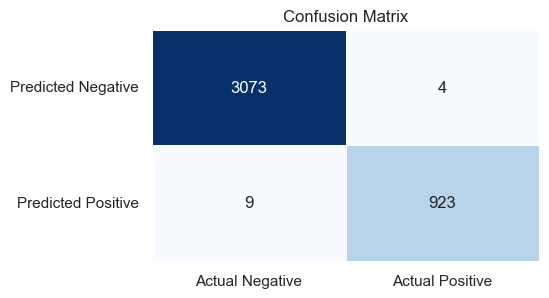

In [7]:
# Display classification report
plot_confusion_matrix(predictions, y_train)

In [8]:
# Make predictions on validation set
predictions = pipeline.predict(X_val)

# Evaluate the model on validation set
print("On validation Dataset:", end = "\n\n")
print("Accuracy : " + str(round(accuracy(predictions, y_val)*100, 2)) + "%")
print("Precision : " + str(round(precision(predictions, y_val)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_val)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_val)*100, 2)) + "%")

On validation Dataset:

Accuracy : 98.84%
Precision : 98.57%
Recall : 96.73%
f1 score : 97.64%


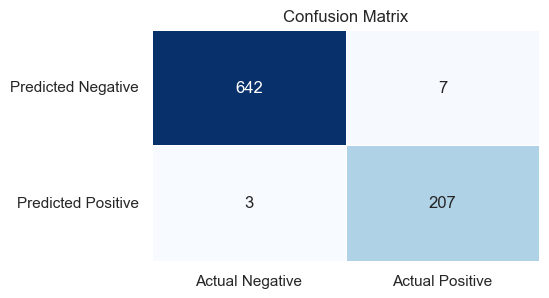

In [9]:
# Display classification report
plot_confusion_matrix(predictions, y_val)

Let's try a grid search on alpha value, the smoothening parameter

In [10]:
params = {"alpha" : [0.1, 0.3, 0.5, 0.7, 0.9, 1, 1.1, 1.3, 1.5, 1.7, 1.9, 2, 2.1]}

grcv = GridSearchCV(estimator = MultinomialNB(),
                    param_grid = params, scoring = f1_score, n_jobs=-1,
                    cv = 5, verbose=3)
pipeline = make_pipeline(CountVectorizer(), grcv)
pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
                              param_grid={'alpha': [0.1, 0.3, 0.5, 0.7, 0.9, 1,
                                                    1.1, 1.3, 1.5, 1.7, 1.9, 2,
                                                    2.1]},
                              scoring=<function f1_score at 0x000002239CC6C4C0>,
                              verbose=3))])

In [11]:
pipeline[1].best_estimator_

MultinomialNB(alpha=0.1)

In [12]:
pipeline_nb = make_pipeline(CountVectorizer(), MultinomialNB(alpha = 0.1))
pipeline_nb.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB(alpha=0.1))])

In [13]:
# Make predictions on training set
predictions = pipeline.predict(X_train)

# Evaluate the model on training set
print("On training Dataset:", end = "\n\n")
print("Accuracy : " + str(round(accuracy(predictions, y_train)*100, 2)) + "%")
print("Precision : " + str(round(precision(predictions, y_train)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_train)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_train)*100, 2)) + "%")

On training Dataset:

Accuracy : 99.93%
Precision : 99.68%
Recall : 100.0%
f1 score : 99.84%


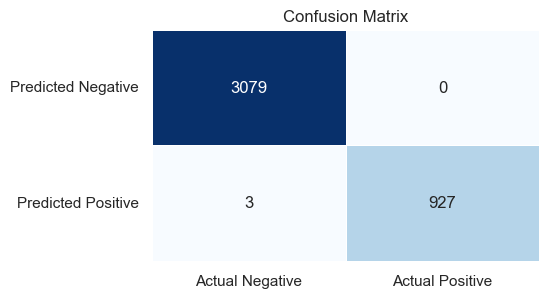

In [14]:
# Display classification report
plot_confusion_matrix(predictions, y_train)

In [15]:
# Make predictions on validation set
predictions = pipeline.predict(X_val)

# Evaluate the model on validation set
print("On validation Dataset:", end = "\n\n")
print("Accuracy : " + str(round(accuracy(predictions, y_val)*100, 2)) + "%")
print("Precision : " + str(round(precision(predictions, y_val)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_val)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_val)*100, 2)) + "%")

On validation Dataset:

Accuracy : 98.72%
Precision : 98.1%
Recall : 96.73%
f1 score : 97.41%


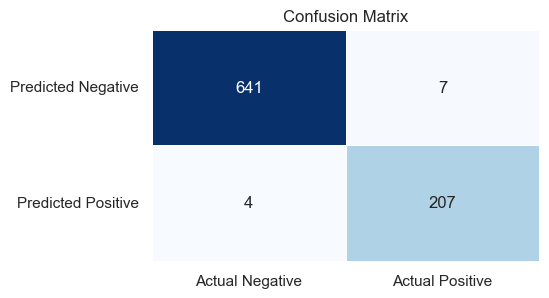

In [16]:
# Display classification report
plot_confusion_matrix(predictions, y_val)

# Logistic Regression

In [17]:
pipeline_lr = make_pipeline(CountVectorizer(), LogisticRegression(random_state = 42))
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [18]:
# Make predictions on training set
predictions = pipeline_lr.predict(X_train)

# Evaluate the model on training set
print("On training Dataset:", end = "\n\n")
print("Accuracy : " + str(round(accuracy(predictions, y_train)*100, 2)) + "%")
print("Precision : " + str(round(precision(predictions, y_train)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_train)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_train)*100, 2)) + "%")

On training Dataset:

Accuracy : 100.0%
Precision : 100.0%
Recall : 100.0%
f1 score : 100.0%


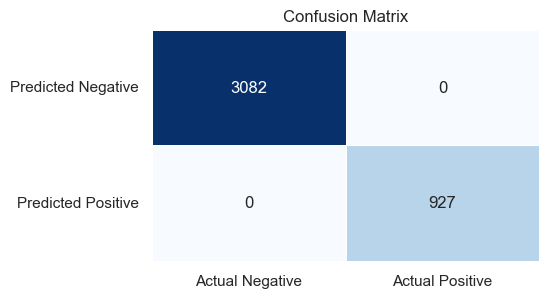

In [19]:
# Display classification report
plot_confusion_matrix(predictions, y_train)

In [20]:
# Make predictions on validation set
predictions = pipeline_lr.predict(X_val)

# Evaluate the model on validation set
print("On validation Dataset:", end = "\n\n")
print("Accuracy : " + str(round(accuracy(predictions, y_val)*100, 2)) + "%")
print("Precision : " + str(round(precision(predictions, y_val)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_val)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_val)*100, 2)) + "%")

On validation Dataset:

Accuracy : 98.49%
Precision : 97.63%
Recall : 96.26%
f1 score : 96.94%


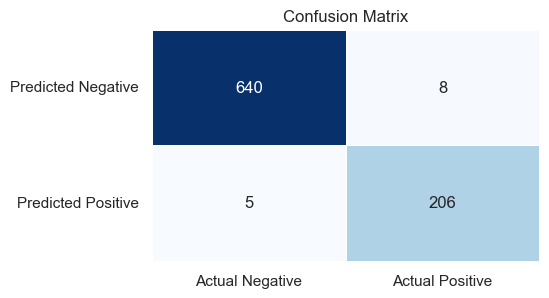

In [21]:
# Display classification report
plot_confusion_matrix(predictions, y_val)

Here, we have a model overfitting, that results in the model giving a score of 100% on all metric for the training dataset. Hence a hyperparameter tuning is not needed here.

# Random Forest Classifier

In [22]:
pipeline = make_pipeline(CountVectorizer(), RandomForestClassifier(random_state = 42, max_depth = 100))
pipeline.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=100, random_state=42))])

In [23]:
# Make predictions on training set
predictions = pipeline.predict(X_train)

# Evaluate the model on training set
print("On training Dataset:", end = "\n\n")
print("Accuracy : " + str(round(accuracy(predictions, y_train)*100, 2)) + "%")
print("Precision : " + str(round(precision(predictions, y_train)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_train)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_train)*100, 2)) + "%")

On training Dataset:

Accuracy : 99.83%
Precision : 100.0%
Recall : 99.24%
f1 score : 99.62%


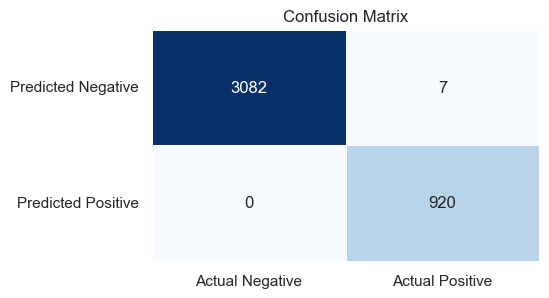

In [24]:
# Display classification report
plot_confusion_matrix(predictions, y_train)

In [25]:
# Make predictions on validation set
predictions = pipeline.predict(X_val)

# Evaluate the model on validation set
print("On validation Dataset:", end = "\n\n")
print("Accuracy : " + str(round(accuracy(predictions, y_val)*100, 2)) + "%")
print("Precision : " + str(round(precision(predictions, y_val)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_val)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_val)*100, 2)) + "%")

On validation Dataset:

Accuracy : 96.74%
Precision : 100.0%
Recall : 86.92%
f1 score : 93.0%


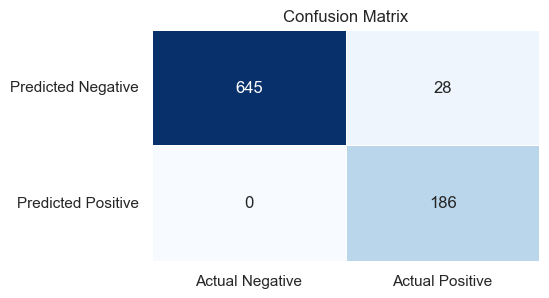

In [26]:
# Display classification report
plot_confusion_matrix(predictions, y_val)

Now, a Grid Search on maximum depth for Random Forest

In [27]:
params = {"max_depth": [i for i in range(60, 81)]}

grcv = GridSearchCV(estimator = RandomForestClassifier(random_state=42, n_jobs=-1),
                    param_grid = params, scoring = f1_score, n_jobs=-1,
                    cv = 5, verbose=3)
pipeline = make_pipeline(CountVectorizer(), grcv)
pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(n_jobs=-1,
                                                               random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [60, 61, 62, 63, 64, 65,
                                                        66, 67, 68, 69, 70, 71,
                                                        72, 73, 74, 75, 76, 77,
                                                        78, 79, 80]},
                              scoring=<function f1_score at 0x000002239CC6C4C0>,
                              verbose=3))])

In [28]:
pipeline[1].best_estimator_

RandomForestClassifier(max_depth=60, n_jobs=-1, random_state=42)

In [29]:
pipeline_rf = make_pipeline(CountVectorizer(), RandomForestClassifier(random_state = 42, max_depth=60, n_jobs=-1))
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=60, n_jobs=-1,
                                        random_state=42))])

In [30]:
# Make predictions on training set
predictions = pipeline_rf.predict(X_train)

# Evaluate the model on training set
print("On training Dataset:", end = "\n\n")
print("Accuracy : " + str(round(accuracy(predictions, y_train)*100, 2)) + "%")
print("Precision : " + str(round(precision(predictions, y_train)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_train)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_train)*100, 2)) + "%")

On training Dataset:

Accuracy : 99.35%
Precision : 100.0%
Recall : 97.2%
f1 score : 98.58%


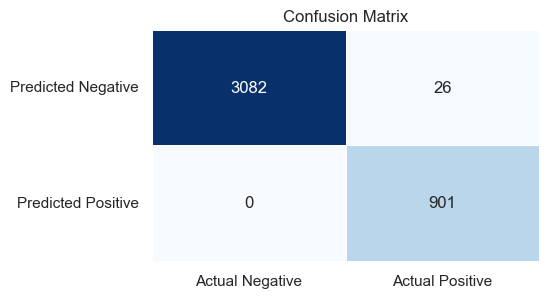

In [31]:
# Display classification report
plot_confusion_matrix(predictions, y_train)

In [32]:
# Make predictions on validation set
predictions = pipeline_rf.predict(X_val)

# Evaluate the model on validation set
print("On validation Dataset:", end = "\n\n")
print("Accuracy : " + str(round(accuracy(predictions, y_val)*100, 2)) + "%")
print("Precision : " + str(round(precision(predictions, y_val)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_val)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_val)*100, 2)) + "%")

On validation Dataset:

Accuracy : 94.99%
Precision : 100.0%
Recall : 79.91%
f1 score : 88.83%


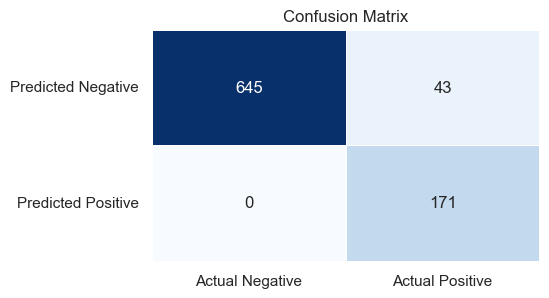

In [33]:
# Display classification report
plot_confusion_matrix(predictions, y_val)

#### Testing the three models on testing set

In [34]:
models = [pipeline_nb, pipeline_lr, pipeline_rf]

df = pd.DataFrame(np.zeros((3, 4)))
df.index = ["Naive Bayes", "Logistic Regression", "Random Forest"]
df.columns = ["Accuracy", "Precision", "Recall", "f1 score"]


for i in range(3):
    model = models[i]
    predictions = model.predict(X_test)
    df.iloc[i,0] = str(round(accuracy(predictions, y_test)*100, 2)) + "%"
    df.iloc[i,1] = str(round(precision(predictions, y_test)*100, 2)) + "%"
    df.iloc[i,2] = str(round(recall(predictions, y_test)*100, 2)) + "%"
    df.iloc[i,3] = str(round(f1_score(predictions, y_test)*100, 2)) + "%"

print(df)

                    Accuracy Precision  Recall f1 score
Naive Bayes           99.07%    98.67%   97.8%   98.23%
Logistic Regression   99.07%     99.1%  97.36%   98.22%
Random Forest          95.7%    100.0%   83.7%   91.13%


#### Conclusion

Although Naive Bayes and Logistic Regression seems to show very similar (and maximum scoring) metric in Accuracy and f1 score, we should choose the Logistic Regression, since its precision is higher. In spam classification, marking a ham as spam is more expensive than marking a spam as ham as important mails/messages might not reach the receiver since they were misclassified as a spam. Thus, we have to reduce the False Positive, hence maximizing Precision

$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

Hence in conclusion, we should go with Logistic regression.